In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import minerl
from tqdm import tqdm

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utilities import flatten, unflatten, to_batch_shape, to_torch_channels
from collections import defaultdict
import coordconv

/home/marthinwurer/.pyenv/versions/3.9.6/envs/minerl/lib/python3.9/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 8]

In [4]:
# BATCH_SIZE = 512
BATCH_SIZE = 256
# BATCH_SIZE = 128
# BATCH_SIZE = 64
# BATCH_SIZE = 32
# BATCH_SIZE = 8
LEARNING_RATE = 0.0001
in_dim = 64

In [5]:
from dataset_preprocessing import MineRlSequenceDataset, MineRlImageDataset

In [6]:
dataset = MineRlImageDataset("data/npy_obtain_diamond_all")
len(dataset)

1916597

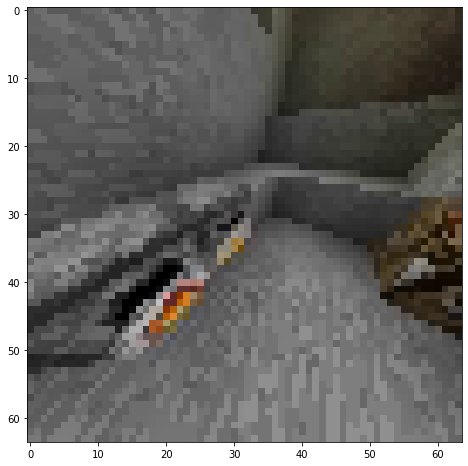

In [7]:
plt.imshow(dataset[10000])

In [8]:
from torch.utils.data import DataLoader

In [9]:
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def calc_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [11]:
def train_batch(inputs, model, optimizer, loss_func, scaler):
    # get the inputs
    inputs = inputs.cuda()

    if torch.isnan(inputs).any():
        print("There's a NaN input!")
        return None

    # zero the parameter gradients
    optimizer.zero_grad()
    
    with torch.cuda.amp.autocast():

        # forward + backward + optimize
        outputs, latents = model(inputs)

        if torch.isnan(outputs).any():
            print("There's a NaN output!")
            return None
        loss = loss_func(inputs, outputs, latents)
    
    scaler.scale(loss).backward()
    
#     plot_grad_flow(model.named_parameters())
    scaler.unscale_(optimizer)
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    return loss

In [12]:
class AELatent(nn.Module):
    def __init__(self, latent_size, input_size):
        super().__init__()
        self.mu = nn.Linear(input_size, latent_size)
        self.bn = nn.LazyBatchNorm1d()
    
    def forward(self, input):
        x = input
        x = torch.flatten(x, 1)
        mu = self.mu(x)
        z = self.bn(mu)
        return z

In [13]:
x = torch.arange(16, dtype=torch.float).reshape((4, -1))
x, x.shape

(tensor([[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]),
 torch.Size([4, 4]))

In [14]:
x = x.reshape(-1, 2)
x, x.shape

(tensor([[ 0.,  1.],
         [ 2.,  3.],
         [ 4.,  5.],
         [ 6.,  7.],
         [ 8.,  9.],
         [10., 11.],
         [12., 13.],
         [14., 15.]]),
 torch.Size([8, 2]))

In [15]:
x = x.reshape(-1, 4)
x

tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])

In [16]:
F.softmax(x)

/tmp/ipykernel_680535/4216236698.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(x)


tensor([[0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439],
        [0.0321, 0.0871, 0.2369, 0.6439]])

In [17]:
F.one_hot(x.argmax(1), 4)

tensor([[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1]])

In [18]:
class CategoricalLatent(nn.Module):
    def __init__(self, input_size, categoricals, classes):
        super().__init__()
        self.mu = nn.Linear(input_size, categoricals * classes)
        self.classes = classes
    
    def forward(self, input):
        x = input
        x = torch.flatten(x, 1)
        # starts as torch.Size([256, 1024]), (batch, values)
        # reshape into groups
        initial_shape = x.shape
        x = F.softplus(self.mu(x))
        reshaped = x.reshape(-1, self.classes)
        softmaxed = F.softmax(reshaped, dim=1)
        drawn = F.one_hot(softmaxed.argmax(1), self.classes)
        through = drawn + softmaxed - softmaxed.detach()
        z = through.reshape(initial_shape)
        
        
        return z

In [19]:
model = CategoricalLatent(1024, 32, 32)
model(torch.randn(1, 1024))

tensor([[0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward>)

In [20]:
model.cuda()

CategoricalLatent(
  (mu): Linear(in_features=1024, out_features=1024, bias=True)
)

In [21]:
class TransposeDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        activation = nn.ReLU
        deconv = nn.ConvTranspose2d

        self.decoder = nn.Sequential(
            nn.LazyBatchNorm2d(),
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(128, 64, 5, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(64, 32, 6, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            deconv(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded

In [37]:
class ConvActNormLayer(nn.Module):
    # Does not actually work that well: needs more space for the intermediate layer outputs for backprop
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super().__init__()
        activation = nn.LeakyReLU
#         conv = coordconv.CoordConv2d
        conv = nn.Conv2d

        self.layer = nn.Sequential(
            conv(in_channels, out_channels, kernel_size, padding=padding),
            activation(),
            nn.LazyBatchNorm2d(),
        )
    
    def forward(self, input):
        return self.layer(input)

In [75]:
class UpsampleDecoderV2(nn.Module):
    def __init__(self, conv=nn.Conv2d):
        super().__init__()
        activation = nn.LeakyReLU
        
        

        # starts as 1x1x1024
        self.decoder = nn.Sequential(
            nn.LazyBatchNorm2d(),
            nn.Upsample(scale_factor=2), # 2
            ConvActNormLayer(1024, 512, 5, padding=2),
            nn.Upsample(scale_factor=2), # 4
#             ConvActNormLayer(512, 512, 3, padding=1),
            ConvActNormLayer(512, 256, 5, padding=2),
            nn.Upsample(scale_factor=2), # 8
            ConvActNormLayer(256, 128, 5, padding=2),
            nn.Upsample(scale_factor=2), # 16
            ConvActNormLayer(128, 64, 5, padding=2),
            nn.Upsample(scale_factor=2), # 32
            ConvActNormLayer(64, 64, 5, padding=2),
            nn.Upsample(scale_factor=2), # 64
#             coordconv.CoordConv2d(16, 3, 3, padding=1),
#             coordconv.CoordConv2d(32, 3, 3, padding=1),
            nn.Conv2d(64, 3, 5, padding=2),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded

In [76]:
class StrideEncoder(nn.Module):
    def __init__(self, conv=nn.Conv2d):
        super().__init__()
        activation = nn.LeakyReLU
        

#         activation = nn.ReLU
        conv = nn.Conv2d
        deconv = nn.ConvTranspose2d
        self.encoder = nn.Sequential(
            conv(3, 32, 4, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            conv(32, 64, 4, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            conv(64, 128, 4, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
            conv(128, 256, 4, stride=2),
            activation(),
            nn.LazyBatchNorm2d(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded

In [77]:
class My_AE(nn.Module):
    def __init__(self):
        super().__init__()
#         activation = nn.ReLU
        activation = nn.LeakyReLU

        conv = nn.Conv2d
        deconv = nn.ConvTranspose2d
        self.encoder = StrideEncoder()
        
        self.latent = AELatent(1024, 1024)
#         self.latent = CategoricalLatent(1024, 32, 32)
        
#         self.unlatent = nn.Linear(1024, 1024)
        
        # starts as 1x1x1024
#         self.decoder = TransposeDecoder()
        self.decoder = UpsampleDecoderV2()
    
    def forward(self, input):
        encoded = self.encoder(input)
        latent = self.latent(encoded)
#         x = self.unlatent(latent)
        x = unflatten(latent)
        decoded = self.decoder(x)
        return decoded, latent

In [78]:
def ae_loss(inputs, outputs, latents):
    recon = F.mse_loss(inputs, outputs)
    return recon

In [79]:
model = My_AE().cuda()
calc_params(model)

19255971

In [80]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.000001)
scaler = torch.cuda.amp.GradScaler()

In [81]:
loss_func = ae_loss

In [82]:
data = next(iter(train_dataloader))
image = data.transpose(-1, 1).cuda() / 255
outputs, latents = model(image)
outputs.shape, latents.shape

(torch.Size([256, 3, 64, 64]), torch.Size([256, 1024]))

In [83]:
STATS = defaultdict(list)

In [84]:
loss_steps = 50
epochs = 1
model.train()

for epoch in range(epochs):
    with tqdm(train_dataloader, unit="batch") as t:
        running_loss = 0
        for i, data in enumerate(t):
            # get the inputs
    #         current_state, action, reward, next_state, done = data
            image = data.transpose(-1, 1).cuda() / 255

    #         loss = train_batch(image, model, optimizer, autoencoder.spectral_loss)
            full_loss = train_batch(image, model, optimizer, loss_func, scaler)

            if isinstance(full_loss, tuple):
                loss = full_loss[0].item()
                STATS['raw_losses'].append(loss)
                STATS['recons'].append(full_loss[1].item())
                STATS['kls'].append(full_loss[2].item())
            else:
                loss = full_loss.item()
                STATS['raw_losses'].append(loss)

            # print statistics
            running_loss += loss
            if i % loss_steps == loss_steps - 1:  # print every N mini-batches
                string = '[%d, %5d] loss: %.8f' % (epoch + 1, i + 1, running_loss / loss_steps)
                t.set_postfix_str(string)
                STATS['losses'].append(running_loss / loss_steps)
    #             scheduler.step(running_loss)
                running_loss = 0.0

 92%|███████████ | 6881/7487 [13:25<01:13,  8.29batch/s, [1,  6850] loss: 0.00278295]/tmp/ipykernel_680535/2947920170.py:26: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
100%|████████████| 7487/7487 [14:37<00:00,  8.53batch/s, [1,  7450] loss: 0.00279900]


10k, 50k, 60k, 100k, 120k, 130k, 140k, 160k, 180k, 230k, 400k

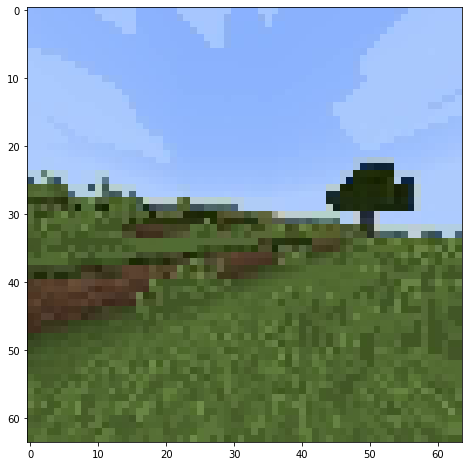

In [85]:
recon_target = dataset[130000]
plt.imshow(recon_target)

In [86]:
image = torch.from_numpy(to_batch_shape(recon_target).transpose(0, 3, 1, 2)).cuda() / 255
image.shape

torch.Size([1, 3, 64, 64])

In [87]:
model.eval()
outputs, latents = model(image)
op = outputs.detach().cpu().numpy().transpose(0, 2, 3, 1)

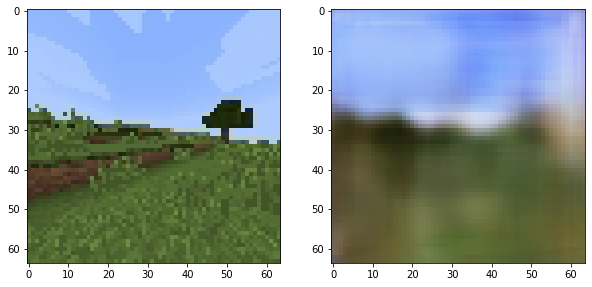

In [88]:
plt.subplot(1, 2, 1)
plt.imshow(recon_target)
plt.subplot(1, 2, 2)

plt.imshow(op[0])

In [54]:
from delve import CheckLayerSat
tracker = CheckLayerSat("my_experiment", save_to="plotcsv", modules=model, device=image.device)

added layer encoder-encoder-0
Skipping encoder-encoder-1
Skipping encoder-encoder-2
added layer encoder-encoder-3
Skipping encoder-encoder-4
Skipping encoder-encoder-5
added layer encoder-encoder-6
Skipping encoder-encoder-7
Skipping encoder-encoder-8
added layer encoder-encoder-9
Skipping encoder-encoder-10
Skipping encoder-encoder-11
added layer latent-mu
Skipping latent-bn
Skipping decoder-decoder-0
Skipping decoder-decoder-1
added layer decoder-decoder-2-layer-0
Skipping decoder-decoder-2-layer-1
Skipping decoder-decoder-2-layer-2
Skipping decoder-decoder-3
added layer decoder-decoder-4-layer-0
Skipping decoder-decoder-4-layer-1
Skipping decoder-decoder-4-layer-2
Skipping decoder-decoder-5
added layer decoder-decoder-6-layer-0
Skipping decoder-decoder-6-layer-1
Skipping decoder-decoder-6-layer-2
Skipping decoder-decoder-7
added layer decoder-decoder-8-layer-0
Skipping decoder-decoder-8-layer-1
Skipping decoder-decoder-8-layer-2
Skipping decoder-decoder-9
added layer decoder-decoder

  1%|▌                                            | 101/7487 [00:08<10:57, 11.24it/s]


my_experiment_lsat_eval_epoch_0.png


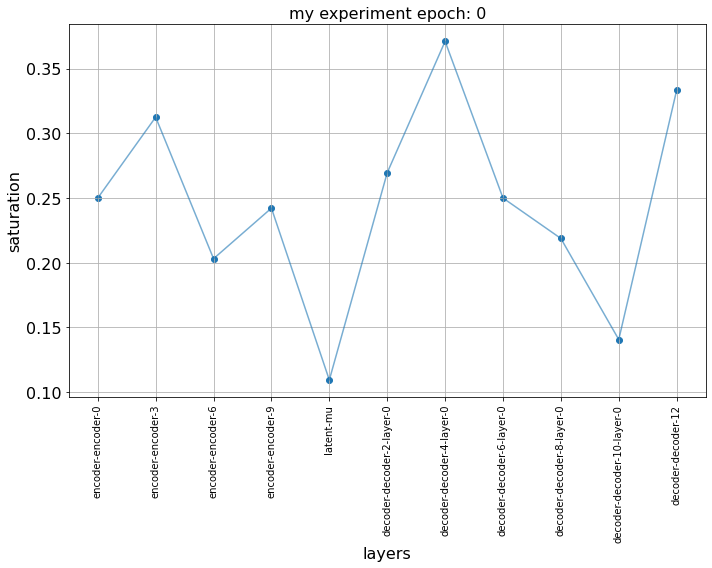

In [55]:
count = 0
for data in tqdm(train_dataloader):
    if count > 100:
        break
    count += 1
#     data = next(iter(train_dataloader))
    image = data.transpose(-1, 1).cuda() / 255
    outputs, latents = model(image)
tracker.add_saturations()